In [ ]:
# Install Java
!apt-get install openjdk-11-jdk -y

# Download Spark from a working mirror
!wget https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract Spark
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz

# Install findspark
!pip install -q findspark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Crystallization Analysis") \
    .getOrCreate()


Load and Inspect Dataset in PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Crystoper Spark Analysis") \
    .getOrCreate()

# Load CSV
df = spark.read.csv("synthetic_protein_crystallization_dataset_v2.csv", header=True, inferSchema=True)

# Show schema and sample data
df.printSchema()
df.show(5)


root
 |-- Protein_ID: string (nullable = true)
 |-- Sequence_Length: integer (nullable = true)
 |-- Molecular_Weight_kDa: double (nullable = true)
 |-- Isoelectric_Point: double (nullable = true)
 |-- Hydrophobicity: double (nullable = true)
 |-- Secondary_Structure: string (nullable = true)
 |-- Buffer_Type: string (nullable = true)
 |-- Precipitant_Type: string (nullable = true)
 |-- Precipitant_Concentration_%: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- Temperature_C: integer (nullable = true)
 |-- Crystallization_Method: string (nullable = true)
 |-- Crystallized: integer (nullable = true)

+----------+---------------+--------------------+-----------------+--------------+-------------------+-----------+----------------+---------------------------+---+-------------+----------------------+------------+
|Protein_ID|Sequence_Length|Molecular_Weight_kDa|Isoelectric_Point|Hydrophobicity|Secondary_Structure|Buffer_Type|Precipitant_Type|Precipitant_Concentration_%| pH|

Count of Crystallized vs Not Crystallized

In [ ]:
df.groupBy("Crystallized").count().show()


+------------+-----+
|Crystallized|count|
+------------+-----+
|           1| 4856|
|           0|10144|
+------------+-----+



Average pH, Temperature, Sequence Length per Crystallization Method

In [ ]:
df.groupBy("Crystallization_Method") \
  .agg(
      count("*").alias("Trials"),
      avg("pH").alias("Avg_pH"),
      avg("Temperature_C").alias("Avg_Temperature"),
      avg("Sequence_Length").alias("Avg_Seq_Length")
  ).orderBy("Trials", ascending=False).show()


+----------------------+------+------------------+------------------+-----------------+
|Crystallization_Method|Trials|            Avg_pH|   Avg_Temperature|   Avg_Seq_Length|
+----------------------+------+------------------+------------------+-----------------+
|              Dialysis|  1913|  6.76915838996341| 21.25405122843701|523.5253528489284|
|          Sitting-drop|  1909| 6.762598218962814|22.091147197485594|524.9717129387113|
|          Hanging-drop|  1894| 6.747465681098203| 21.19588173178458|537.3743400211193|
|     Counter-diffusion|  1886| 6.772057264050891|21.152173913043477|525.6033934252386|
|  Free interface di...|  1884| 6.813747346072189|   21.223991507431|534.6305732484077|
|            Microbatch|  1852| 6.686933045356376|21.359071274298056|530.3347732181426|
|       Batch under oil|  1831|6.7469688694702485| 21.36974330966685| 530.185690879301|
|       Vapor diffusion|  1831| 6.774167121791367|21.490988530857454|519.3003823047515|
+----------------------+------+-

Most Common Buffer and Precipitant Combinations

In [ ]:
df.groupBy("Buffer_Type", "Precipitant_Type").count().orderBy("count", ascending=False).show(10)


+-----------+----------------+-----+
|Buffer_Type|Precipitant_Type|count|
+-----------+----------------+-----+
|  Phosphate|        PEG 3350|  990|
|       Tris|Ammonium sulfate|  979|
|    Citrate|         Ethanol|  976|
|      HEPES|        PEG 3350|  975|
|       Tris|        PEG 3350|  967|
|      HEPES|Ammonium sulfate|  954|
|  Phosphate|         Ethanol|  954|
|       Tris|             MPD|  932|
|    Citrate|        PEG 3350|  929|
|    Citrate|             MPD|  926|
+-----------+----------------+-----+
only showing top 10 rows



Class Distribution Across Crystallization Methods

In [ ]:
df.groupBy("Crystallization_Method", "Crystallized") \
  .count() \
  .orderBy("Crystallization_Method", "Crystallized").show()


+----------------------+------------+-----+
|Crystallization_Method|Crystallized|count|
+----------------------+------------+-----+
|       Batch under oil|           0| 1472|
|       Batch under oil|           1|  359|
|     Counter-diffusion|           0| 1509|
|     Counter-diffusion|           1|  377|
|              Dialysis|           0|  906|
|              Dialysis|           1| 1007|
|  Free interface di...|           0| 1512|
|  Free interface di...|           1|  372|
|          Hanging-drop|           0| 1555|
|          Hanging-drop|           1|  339|
|            Microbatch|           0| 1480|
|            Microbatch|           1|  372|
|          Sitting-drop|           0|  876|
|          Sitting-drop|           1| 1033|
|       Vapor diffusion|           0|  834|
|       Vapor diffusion|           1|  997|
+----------------------+------------+-----+



# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("synthetic_protein_crystallization_dataset_v2.csv")

# Set seaborn style
sns.set(style="whitegrid")

Bar Plot: Count of Crystallization Methods

/tmp/ipython-input-13-2383634380.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Crystallization_Method", data=df, order=df["Crystallization_Method"].value_counts().index, palette="Set3")


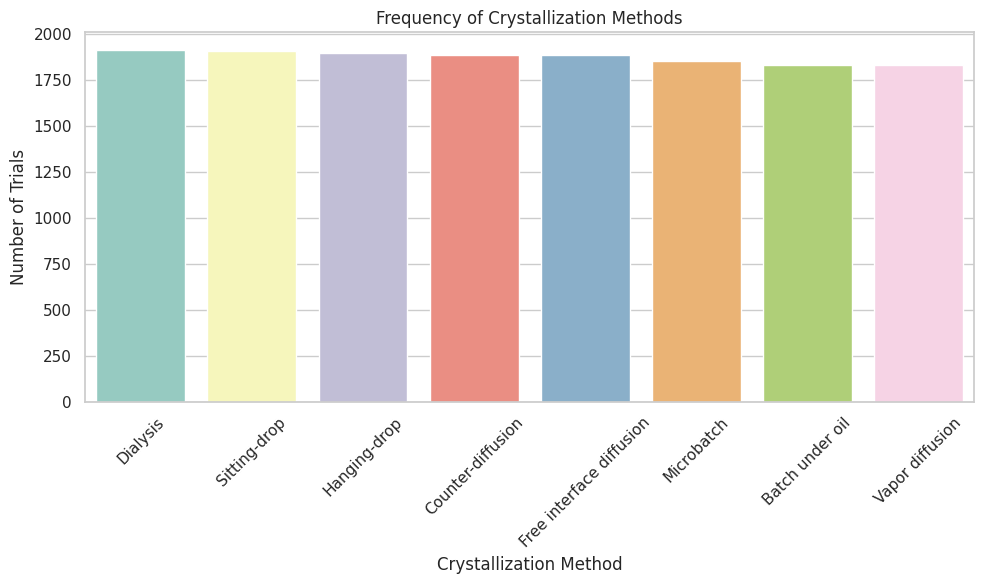

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Crystallization_Method", data=df, order=df["Crystallization_Method"].value_counts().index, palette="Set3")
plt.title("Frequency of Crystallization Methods")
plt.xlabel("Crystallization Method")
plt.ylabel("Number of Trials")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Pie Chart: Crystallized vs Not Crystallized

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming df is already loaded

# Get crystallization counts
crystal_counts = df["Crystallized"].value_counts()

# Prepare data for Plotly
data = pd.DataFrame({
    "Crystallization Status": ["Not Crystallized", "Crystallized"],
    "Count": [crystal_counts[0], crystal_counts[1]]
})

# Create interactive pie chart
fig = px.pie(
    data,
    names="Crystallization Status",
    values="Count",
    title="Crystallization Success Distribution",
    color="Crystallization Status",
    color_discrete_map={"Crystallized": "#4CAF50", "Not Crystallized": "#FF6F61"},
    hole=0.4  # Makes it a donut chart for better aesthetics, optional
)

fig.update_traces(textinfo='percent+label')

# Show interactive plot
fig.show()


Line Plot: Average pH per Crystallization Method

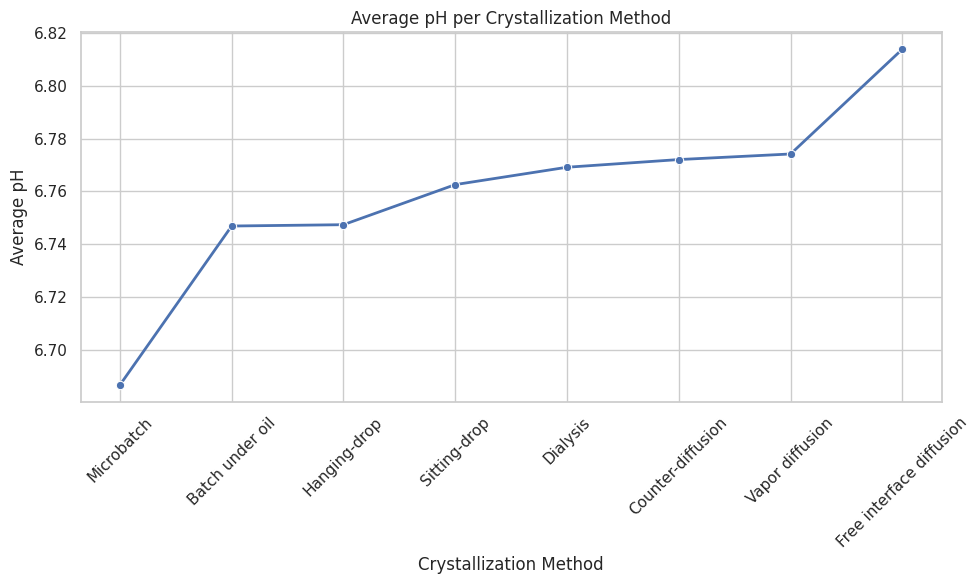

In [ ]:
# 3.
avg_ph = df.groupby("Crystallization_Method")["pH"].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_ph.index, y=avg_ph.values, marker="o", linewidth=2)
plt.title("Average pH per Crystallization Method")
plt.xlabel("Crystallization Method")
plt.ylabel("Average pH")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Line Plot: Average Temperature per Crystallization Method

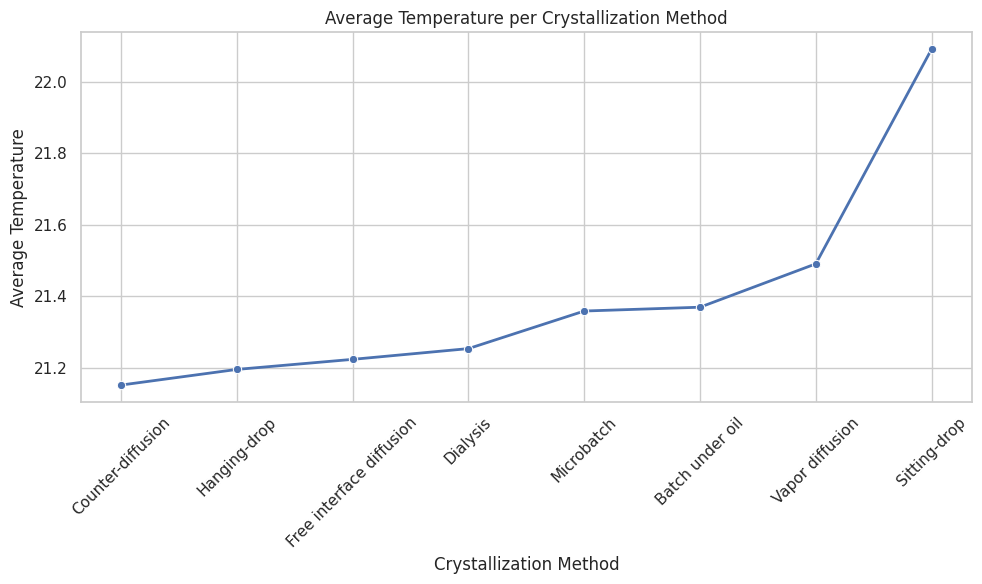

In [ ]:

avg_ph = df.groupby("Crystallization_Method")["Temperature_C"].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_ph.index, y=avg_ph.values, marker="o", linewidth=2)
plt.title("Average Temperature per Crystallization Method")
plt.xlabel("Crystallization Method")
plt.ylabel("Average Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Bar Plot: Successful Crystallizations by Method

/tmp/ipython-input-28-4208209036.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=success_counts.index, y=success_counts.values, palette="coolwarm")


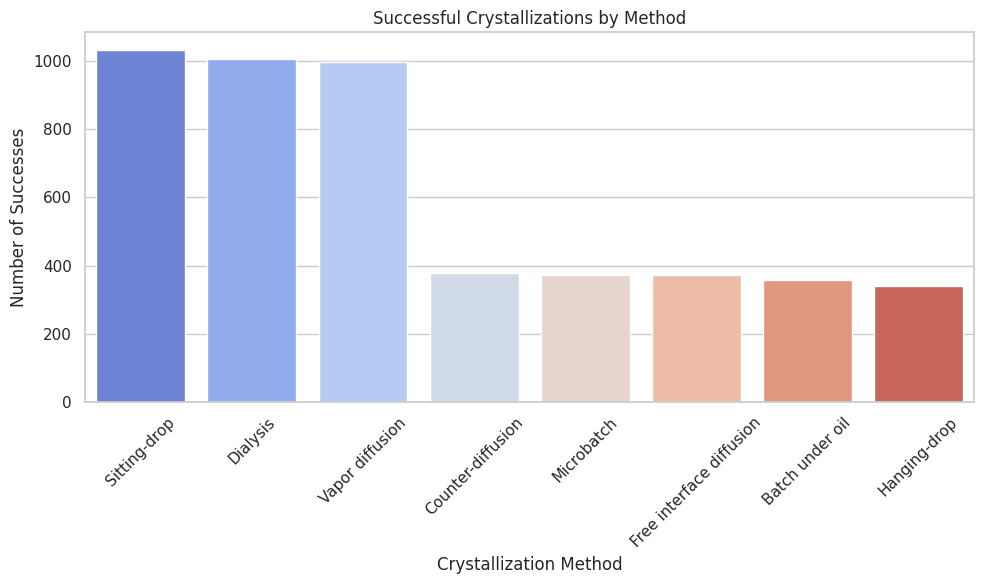

In [ ]:
# 5.
success_counts = df[df["Crystallized"] == 1]["Crystallization_Method"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=success_counts.index, y=success_counts.values, palette="coolwarm")
plt.title("Successful Crystallizations by Method")
plt.xlabel("Crystallization Method")
plt.ylabel("Number of Successes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-26-3266401401.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Crystallized", y="Sequence_Length", data=df, palette="muted", ci=None)
/tmp/ipython-input-26-3266401401.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Crystallized", y="Sequence_Length", data=df, palette="muted", ci=None)


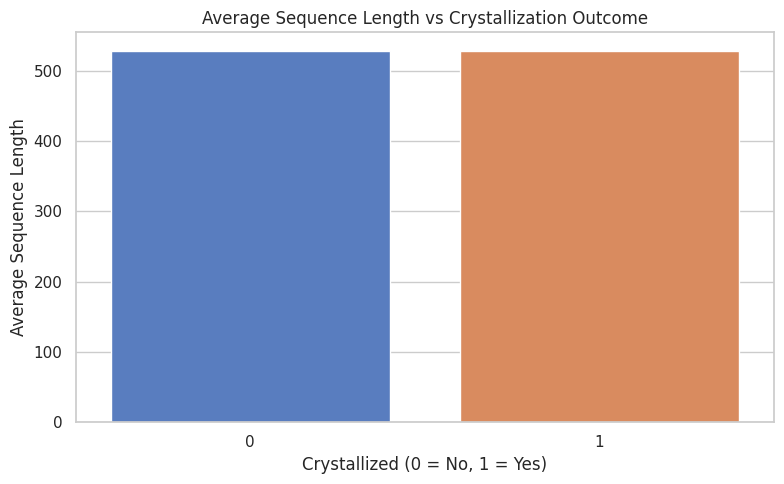

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Crystallized", y="Sequence_Length", data=df, palette="muted", ci=None)
plt.title("Average Sequence Length vs Crystallization Outcome")
plt.xlabel("Crystallized (0 = No, 1 = Yes)")
plt.ylabel("Average Sequence Length")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("synthetic_protein_crystallization_dataset_v2.csv")

# Encode categorical features
categorical_cols = ["Secondary_Structure", "Buffer_Type", "Precipitant_Type", "Crystallization_Method"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for inverse transform if needed

# Define features and target
X = df.drop(columns=["Protein_ID", "Crystallized"])
y = df["Crystallized"]

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9756666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2051
           1       0.98      0.94      0.96       949

    accuracy                           0.98      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.98      0.98      0.98      3000



we can test our input here


In [ ]:
import numpy as np

sample_input = {
    "Sequence_Length": 152,
    "Molecular_Weight_kDa": 45.96,
    "Isoelectric_Point": 9.22,
    "Hydrophobicity": 0.391,
    "Secondary_Structure": "Alpha",
    "Buffer_Type": "Citrate",
    "Precipitant_Type": "PEG 3350",
    "Precipitant_Concentration_%": 25.0,
    "pH": 7.2,
    "Temperature_C": 20,
    "Crystallization_Method": "Free interface diffusion"
}

# Encode the categorical values
for col in ["Secondary_Structure", "Buffer_Type", "Precipitant_Type", "Crystallization_Method"]:
    le = label_encoders[col]
    sample_input[col] = le.transform([sample_input[col]])[0]

# Create input array in correct column order
input_array = np.array([[
    sample_input["Sequence_Length"],
    sample_input["Molecular_Weight_kDa"],
    sample_input["Isoelectric_Point"],
    sample_input["Hydrophobicity"],
    sample_input["Secondary_Structure"],
    sample_input["Buffer_Type"],
    sample_input["Precipitant_Type"],
    sample_input["Precipitant_Concentration_%"],
    sample_input["pH"],
    sample_input["Temperature_C"],
    sample_input["Crystallization_Method"]
]])

# Predict
prediction = model.predict(input_array)[0]
print("Prediction:", "Crystallized ✅" if prediction == 1 else "Not Crystallized ❌")


Prediction: Not Crystallized ❌


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------
# 1. Load the Dataset
# ------------------------------
df = pd.read_csv("synthetic_protein_crystallization_dataset_v2.csv")

# ------------------------------
# 2. Encode Categorical Features
# ------------------------------
categorical_cols = ["Secondary_Structure", "Buffer_Type", "Precipitant_Type", "Crystallization_Method"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save for later use

# ------------------------------
# 3. Select Top 6 Features Based on Importance
# ------------------------------
selected_features = [
    "Precipitant_Concentration_%",
    "pH",
    "Buffer_Type",
    "Secondary_Structure",
    "Crystallization_Method",
    "Molecular_Weight_kDa"
]

X = df[selected_features]
y = df["Crystallized"]

# ------------------------------
# 4. Split Data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# 5. Train Random Forest Model
# ------------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ------------------------------
# 6. Evaluate the Model
# ------------------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", round(accuracy * 100, 2), "%")
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ------------------------------
# 7. Sample Prediction
# ------------------------------
# Replace with actual user input
sample_input = {
    "Precipitant_Concentration_%": 25.0,
    "pH": 7.2,
    "Buffer_Type": "Citrate",
    "Secondary_Structure": "Alpha",
    "Crystallization_Method": "Free interface diffusion",
    "Molecular_Weight_kDa": 45.96
}

# Encode categorical inputs
for col in ["Buffer_Type", "Secondary_Structure", "Crystallization_Method"]:
    le = label_encoders[col]
    sample_input[col] = le.transform([sample_input[col]])[0]




Model Accuracy: 99.3 %


In [ ]:
# Create input array in correct order
input_array = np.array([[
    sample_input["Precipitant_Concentration_%"],
    sample_input["pH"],
    sample_input["Buffer_Type"],
    sample_input["Secondary_Structure"],
    sample_input["Crystallization_Method"],
    sample_input["Molecular_Weight_kDa"]
]])

# Make Prediction
prediction = model.predict(input_array)[0]
print("------------------------------")
print("\nPrediction:", "Crystallized ✅" if prediction == 1 else "Not Crystallized ❌")
print("------------------------------\n")

------------------------------

Prediction: Not Crystallized ❌
------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [1]:
print("hello")

hello


C:\Users\91874\AppData\Local\Temp\ipykernel_24744\1211015278.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Trials", palette="Blues_d")


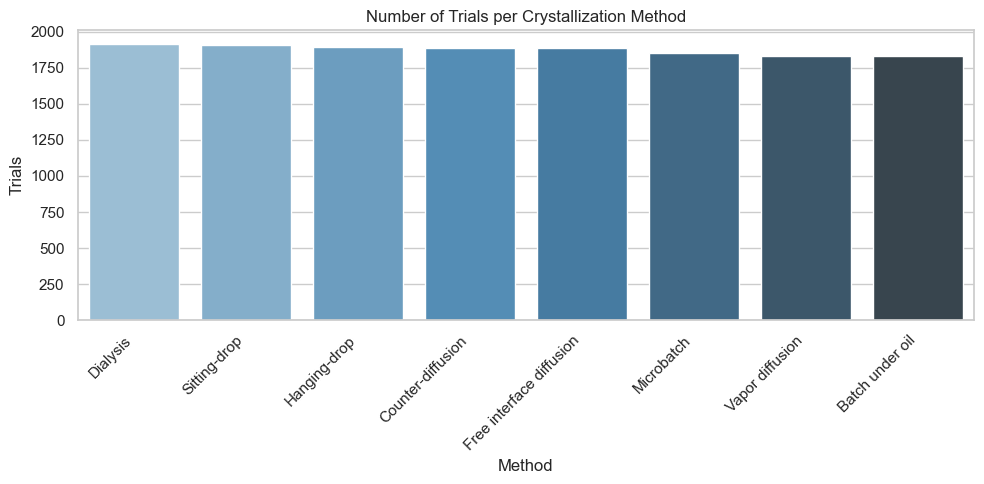

C:\Users\91874\AppData\Local\Temp\ipykernel_24744\1211015278.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Avg Seq Len", palette="Greens_d")


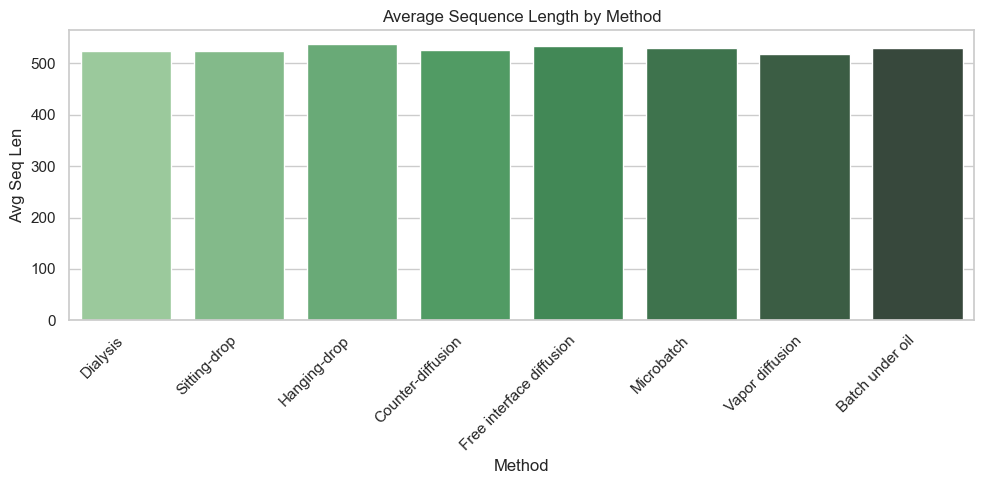

C:\Users\91874\AppData\Local\Temp\ipykernel_24744\1211015278.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Avg pH", palette="Oranges_d")


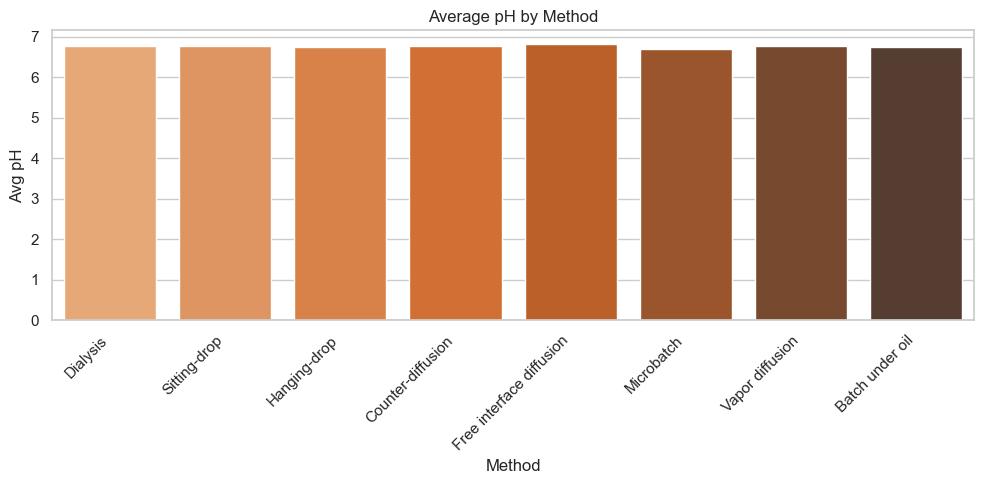

C:\Users\91874\AppData\Local\Temp\ipykernel_24744\1211015278.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Method", y="Avg Temp", palette="Purples_d")


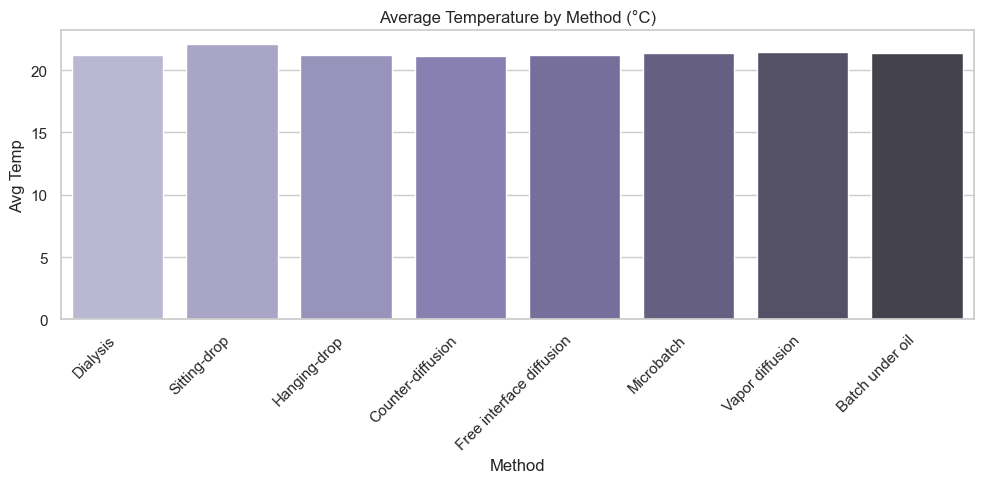

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up aesthetics
sns.set(style="whitegrid")

# Data from your table
data = {
    "Method": [
        "Dialysis", "Sitting-drop", "Hanging-drop", "Counter-diffusion",
        "Free interface diffusion", "Microbatch", "Vapor diffusion", "Batch under oil"
    ],
    "Trials": [1913, 1909, 1894, 1886, 1884, 1852, 1831, 1831],
    "Avg Seq Len": [523.53, 524.97, 537.37, 525.6, 534.63, 530.33, 519.3, 530.19],
    "Avg pH": [6.77, 6.76, 6.75, 6.77, 6.81, 6.69, 6.77, 6.75],
    "Avg Temp": [21.25, 22.09, 21.2, 21.15, 21.22, 21.36, 21.49, 21.37]
}

df = pd.DataFrame(data)

# Plot 1: Trials per Method
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Method", y="Trials", palette="Blues_d")
plt.title("Number of Trials per Crystallization Method")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 2: Avg Sequence Length per Method
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Method", y="Avg Seq Len", palette="Greens_d")
plt.title("Average Sequence Length by Method")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 3: Avg pH per Method
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Method", y="Avg pH", palette="Oranges_d")
plt.title("Average pH by Method")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 4: Avg Temp per Method
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Method", y="Avg Temp", palette="Purples_d")
plt.title("Average Temperature by Method (°C)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
